In [2]:
import pandas as pd

files = [
    ("../dataset/LOS_2m_living_room_home.csv",        "LOS",  2.0,  "LOS 2 m living room"),
    ("../dataset/LOS_4.3m_living_room_corner_home.csv","LOS",  4.3,  "LOS 4.3 m corner"),
    ("../dataset/NLOS_1.56m_open_door_home.csv",       "NLOS", 1.56, "NLOS 1.56 m open door"),
    ("../dataset/NLOS_4.4m_close_door_home.csv",      "NLOS", 4.4,  "NLOS 4.4 m closed door"),
]

dfs = []
for fname, label, d_true, scen in files:
    df = pd.read_csv(fname)
    df["label"] = label              # LOS or NLOS
    df["d_true"] = d_true            # geometric distance from floorplan
    df["scenario"] = scen            # text description
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)


In [3]:
data.info()
data.isna().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 1028 entries, Capture_ID to scenario
dtypes: float64(2), int64(1024), object(2)
memory usage: 31.4+ MB


scenario      0
Capture_ID    0
Distance      0
FP_INDEX      0
CIR979        0
CIR980        0
CIR981        0
CIR982        0
CIR983        0
CIR984        0
CIR985        0
CIR986        0
CIR971        0
CIR972        0
CIR973        0
CIR974        0
CIR975        0
CIR976        0
CIR977        0
CIR978        0
dtype: int64

In [4]:
# how many LOS vs NLOS captures
print(data["label"].value_counts())

# how many samples per scenario
print(data["scenario"].value_counts())


label
LOS     2000
NLOS    2000
Name: count, dtype: int64
scenario
LOS 2 m living room       1000
LOS 4.3 m corner          1000
NLOS 1.56 m open door     1000
NLOS 4.4 m closed door    1000
Name: count, dtype: int64


In [5]:
data.groupby("scenario")["Distance"].describe()



,count,mean,std,min,25%,50%,75%,max
scenario,,,,,,,,
LOS 2 m living room,1000.0,1.935842,0.031392,1.838620,1.913666,1.932427,1.951188,2.063757
LOS 4.3 m corner,1000.0,4.547320,0.101478,4.408936,4.483981,4.502743,4.596550,5.028062
NLOS 1.56 m open door,1000.0,1.935767,0.027932,1.857381,1.913666,1.932427,1.951188,2.026234
NLOS 4.4 m closed door,1000.0,4.769436,0.027090,4.690357,4.746641,4.765403,4.784164,4.840448


In [6]:
data["dist_error"] = data["Distance"] - data["d_true"]

# summary stats by scenario
print(data.groupby("scenario")["dist_error"].agg(["mean", "std", "min", "max"]))


                            mean       std       min       max
scenario                                                      
LOS 2 m living room    -0.064158  0.031392 -0.161380  0.063757
LOS 4.3 m corner        0.247320  0.101478  0.108936  0.728062
NLOS 1.56 m open door   0.375767  0.027932  0.297381  0.466234
NLOS 4.4 m closed door  0.369436  0.027090  0.290357  0.440448


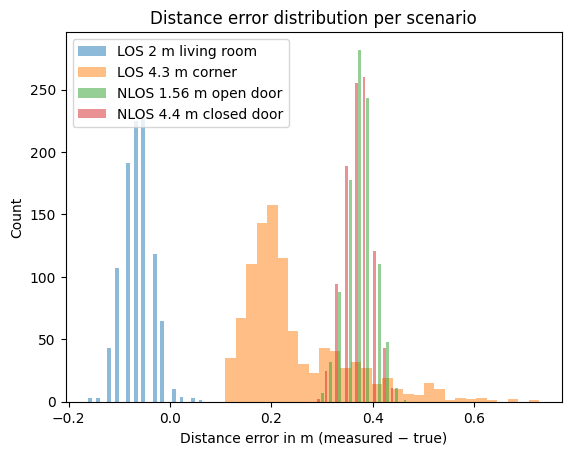

In [7]:
import matplotlib.pyplot as plt

for scen, g in data.groupby("scenario"):
    plt.hist(g["dist_error"], bins=30, alpha=0.5, label=scen)

plt.xlabel("Distance error in m (measured − true)")
plt.ylabel("Count")
plt.legend()
plt.title("Distance error distribution per scenario")
plt.show()


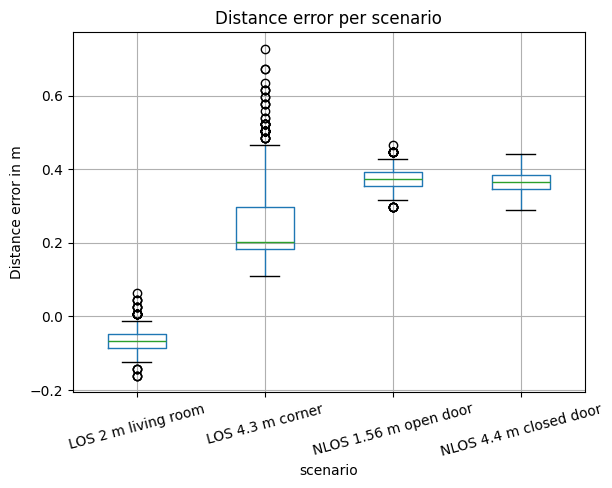

In [8]:
data.boxplot(column="dist_error", by="scenario", rot=15)
plt.ylabel("Distance error in m")
plt.title("Distance error per scenario")
plt.suptitle("")
plt.show()


In [9]:
cir_cols = [c for c in data.columns if c.startswith("CIR")]

data["CIR_energy"] = (data[cir_cols] ** 2).sum(axis=1)

# check typical values
print(data.groupby("scenario")["CIR_energy"].agg(["mean", "std", "min", "max"]))


                                mean           std        min        max
scenario                                                                
LOS 2 m living room     2.878826e+08  8.524321e+06  257836989  317839673
LOS 4.3 m corner        3.031989e+08  1.154936e+07  247032632  355967727
NLOS 1.56 m open door   2.867674e+08  9.364359e+06  238388558  312184238
NLOS 4.4 m closed door  2.332448e+08  1.075630e+07  153872925  277260368


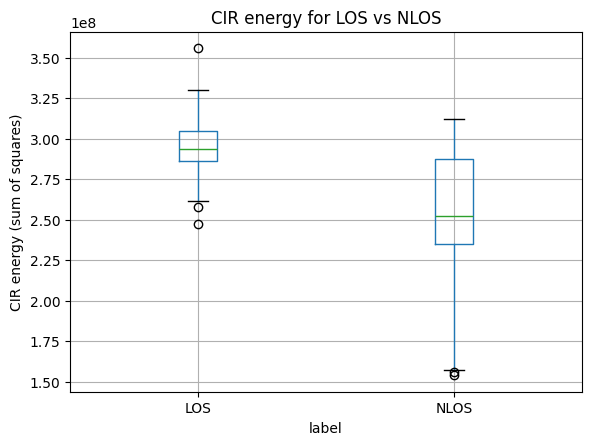

In [10]:
data.boxplot(column="CIR_energy", by="label")
plt.ylabel("CIR energy (sum of squares)")
plt.title("CIR energy for LOS vs NLOS")
plt.suptitle("")
plt.show()


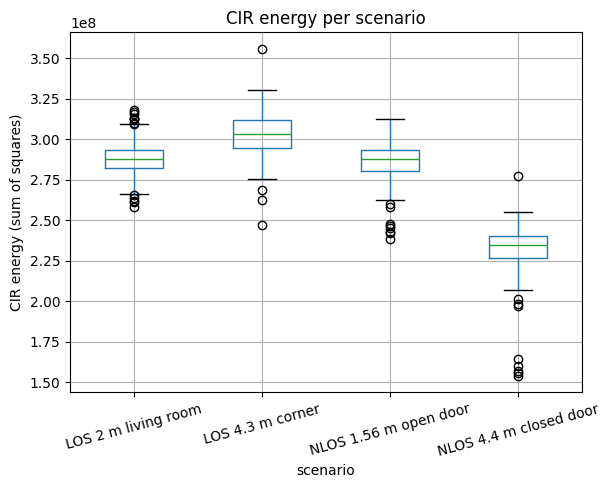

In [11]:
data.boxplot(column="CIR_energy", by="scenario", rot=15)
plt.ylabel("CIR energy (sum of squares)")
plt.title("CIR energy per scenario")
plt.suptitle("")
plt.show()


In [12]:
features = ["FP_AMPL1", "FP_AMPL2", "FP_AMPL3",
            "RXPACC", "STD_NOISE", "MAX_NOISE"]

print(data.groupby("label")[features].mean())


       FP_AMPL1   FP_AMPL2   FP_AMPL3   RXPACC  STD_NOISE  MAX_NOISE
label                                                               
LOS    7040.823  6804.3505  5636.0410  118.004     51.854  1283.1735
NLOS   5815.430  6914.8555  5537.1815  118.004     37.806   887.8640


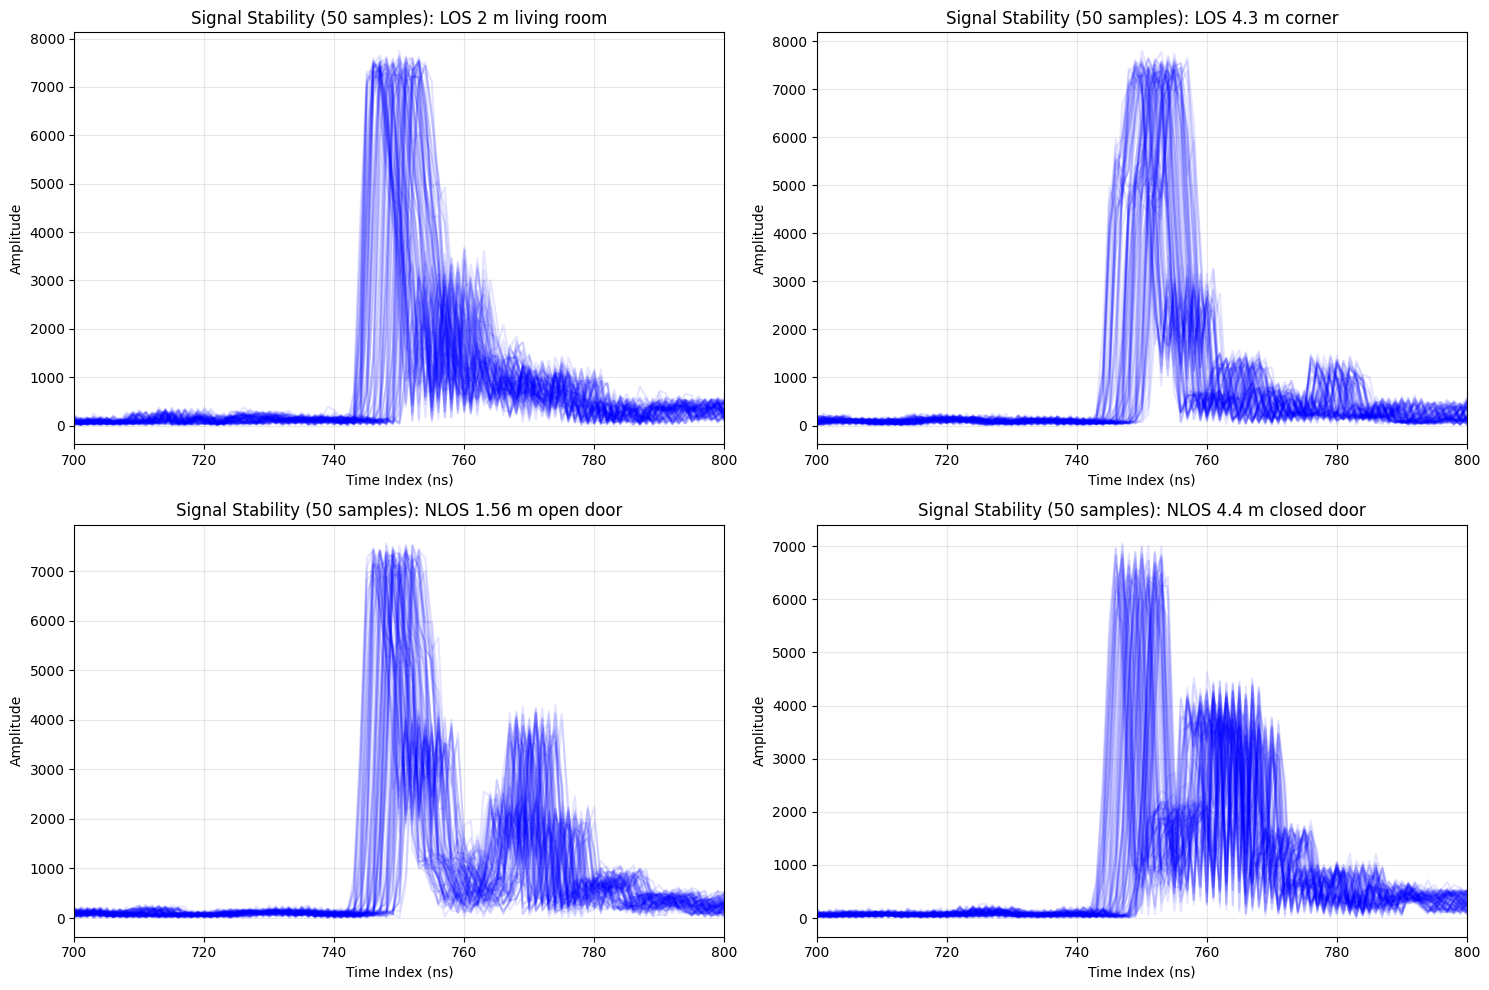

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Setup columns
cir_cols = [c for c in data.columns if c.startswith("CIR") and c[3:].isdigit()]
cir_cols.sort(key=lambda x: int(x[3:])) 

scenarios = data["scenario"].unique()

plt.figure(figsize=(15, 10))

for i, scenario in enumerate(scenarios):
    # 2. Get 50 random samples instead of just 1
    samples = data[data["scenario"] == scenario].iloc[:100] 
    
    plt.subplot(2, 2, i+1)
    
    # 3. Plot all 50 lines with low opacity (alpha=0.1)
    # This creates a "heat map" effect where stable areas are dark
    for _, row in samples.iterrows():
        waveform = row[cir_cols].values.astype(float)
        plt.plot(waveform, color='blue', alpha=0.1) 
        
    plt.title(f"Signal Stability (50 samples): {scenario}")
    plt.xlabel("Time Index (ns)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    
    # Zoom in on the main peak area to see the jitter clearly
    plt.xlim(700, 800) 

plt.tight_layout()
plt.show()

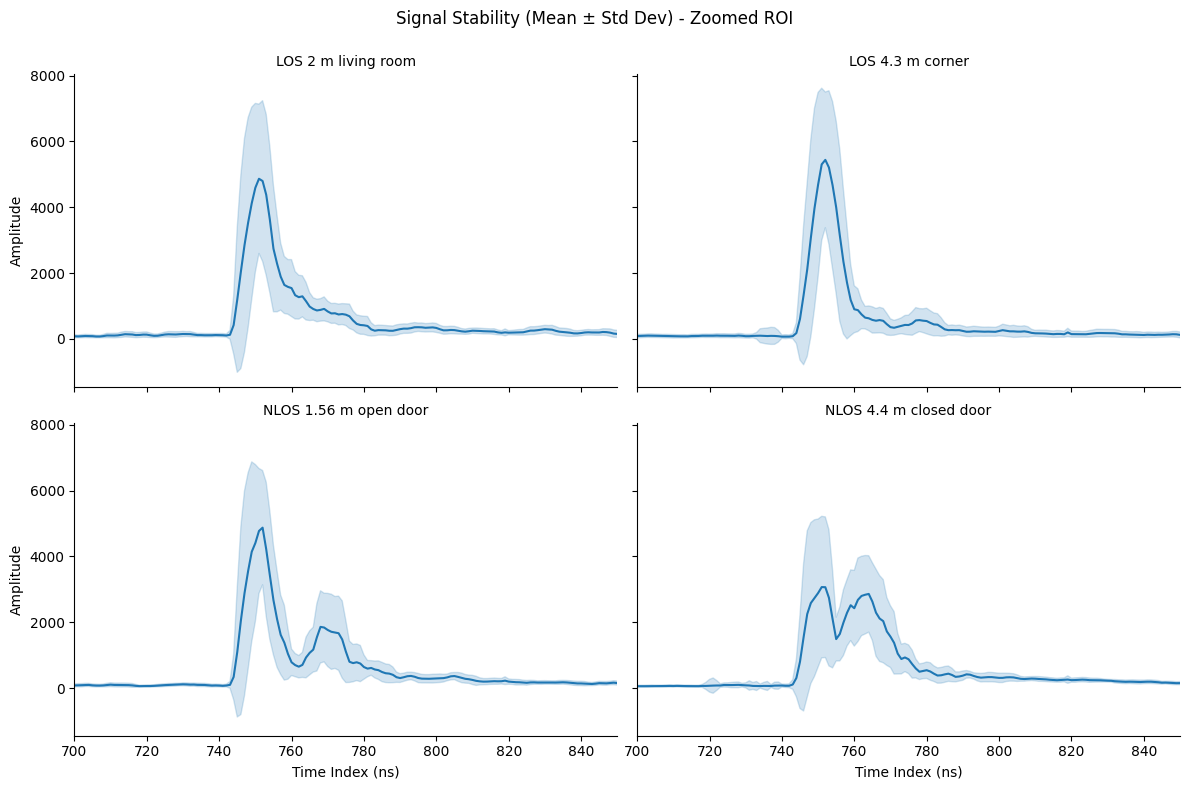

In [29]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare Data
cir_cols = [c for c in data.columns if c.startswith("CIR") and c[3:].isdigit()]
cir_cols.sort(key=lambda x: int(x[3:])) 

# Take top 1000 samples per scenario
plot_data = data.groupby("scenario").head(1000).reset_index(drop=True)

# Melt
melted_data = plot_data.melt(id_vars=["scenario"], value_vars=cir_cols, var_name="Time_Index", value_name="Amplitude")
melted_data["Time_Index"] = melted_data["Time_Index"].str.replace("CIR", "").astype(int)

# 2. Plot
g = sns.relplot(
    data=melted_data,
    x="Time_Index",
    y="Amplitude",
    col="scenario", 
    col_wrap=2,      
    kind="line",
    errorbar='sd',
    height=4, 
    aspect=1.5
)

# --- CHANGE HERE: Zoom in on the Region of Interest (ROI) ---
# Most DWM1001 signals appear between index 700 and 850.
# Adjust these numbers if your signal is slightly shifted.
g.set(xlim=(700, 850))

# 3. Titles and Labels
g.set_titles("{col_name}") 
g.set_axis_labels("Time Index (ns)", "Amplitude")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Signal Stability (Mean ± Std Dev) - Zoomed ROI")

plt.show()

In [31]:
# 1. Identify CIR columns
cir_cols = [c for c in data.columns if c.startswith("CIR") and c[3:].isdigit()]
cir_cols.sort(key=lambda x: int(x[3:])) 

# 2. Extract Max Amplitude and Index
data["Max_Amp"] = data[cir_cols].max(axis=1)
data["Max_Index_Col"] = data[cir_cols].idxmax(axis=1)
data["Max_Index"] = data["Max_Index_Col"].apply(lambda x: int(x[3:]) if isinstance(x, str) else 0)

# 3. Calculate 'Rise Time' (FIXED)
# We divide FP_INDEX by 64 to convert 1/64th ns units to integer indices
data["Rise_Time"] = data["Max_Index"] - (data["FP_INDEX"] / 64)

# 4. Check the results again
features_to_check = ["Max_Amp", "Max_Index", "FP_INDEX", "Rise_Time"]
print(data.groupby("label")[features_to_check].mean())

        Max_Amp  Max_Index    FP_INDEX  Rise_Time
label                                            
LOS    7495.317   750.8495  47884.4990   2.654203
NLOS   6966.384   749.6645  47878.0285   1.570305
